# Introduction to Regression using a Polynomial and  least squares

In [1]:
from __future__ import print_function
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt
import regression_helper as rh
import ipywidgets as widgets

### First cook up some data

Set a range of x-values, then make a "true" set of y-values using a second degree polynomial (e.g. `best_degree=2`).

The general form of the polynomial is: 
## $y=ax^2 + bx + c$

We can set $c=0$ for our purposes so we have two free parameters: $a$ and $b$

Also add noise to the "true" observations

In [2]:
xplot, x, y_data, poly_func, polypars = rh.data_cooker()

### Now we need to define a couple functions

The `parabola` function calculates the equation for a parabola. Note that `c` is skipped since we set it to zero.

In [3]:
def parabola(a,b,x_vec):
    y = [a*x**2 + b*x for x in x_vec]
    return np.array(y)

The `errfun` function calculates a vector of the differences between a vector of data (`y`) and the parabola function estimates at the same locations

In [4]:
def errfun(pars,x,y):
    return y-parabola(*pars,x)

### Plot the data and the true model

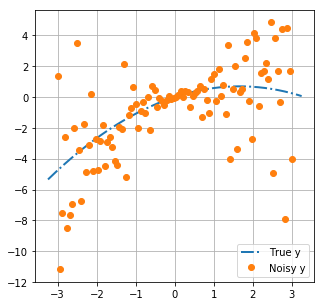

In [5]:
rh.plot_truth(xplot,x,y_data, poly_func)

### Make a function to calculate the sum of squared errors

This function calculates the sum of squared errors between observations and modeled equivalents. It is more general than `errfun` above which only works with the parabola function:

## $SSE=\Phi=\sum_{i=1}^{NPAR}\left(y_{i}-m\left(x_{i}\right)\right)^{2}$
where: 
 ## * $SSE$ is sum of squared errors
 ## * $y_i$ is the $i^{th}$ observation
 ## * $m\left(x_i\right)$ is the modeled equivalent to the $i^{th}$ observation
 
In vector notation, this is expressed as:
## $\Phi=\left(\mathbf{y}-\mathbf{m}\right)^{T}\left(\mathbf{y}-\mathbf{m}\right)$


In [6]:
def sum_squared_errors(y,m):
    y = np.atleast_1d(y)
    m = np.atleast_1d(m)
    sse = np.dot((y-m).T,(y-m))
    return sse

# Use $\Phi$ to evaluate the response surface

## We can look at the response to change is parameters

### First as linear plots

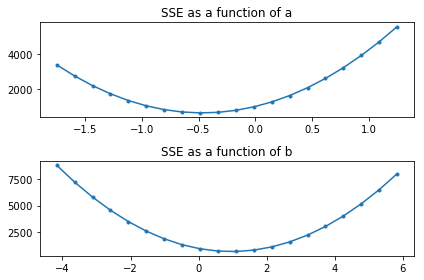

In [7]:
a,b = rh.plot_sse(polypars, x, y_data)

### Or, since `python` is slick, we can make a contour plot

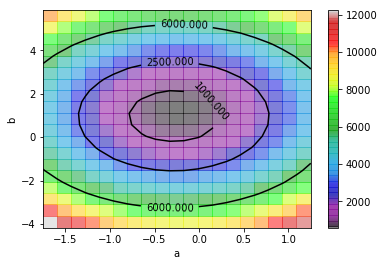

In [8]:
A, B, SSE_AB = rh.contour_sse(a, b, x, y_data)

### Or, even slicker, we can see it in 3D

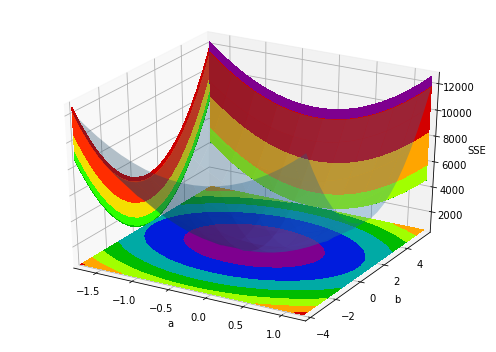

In [9]:
rh.surface_sse(a, b, A, B, SSE_AB)

# Fit a polynomial function

## Now fit a function assuming it will be a polynomial of the same degree (e.g. `best_degree`) as was used to generate the data

In [10]:
# fit the polynomial and then plot the resulting function
sol = spo.least_squares(errfun,[-2,2],args=(x,y_data))
y_fit_pars_best = [*sol.x,0]

# Look at the Jacobian matrix---gradients of parameters wrt. observations

## For each parameter-observation combination, we can see how much the observation value changes due to a small change in the parameter. If $y$ are the observations and $x$ are the parameters, the equation for the $i^th$ observation with respect to the $j^th$ parameter is:  
## $\frac{\partial y_i}{\partial x_j}$
## This can be approximated by finite differences as :  
## $\frac{\partial y_i}{\partial x_j}~\frac{y\left(x+\Delta x \right)-y\left(x\right)}{\Delta x}$

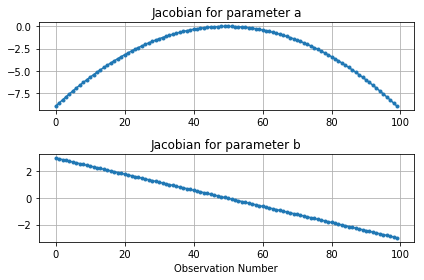

In [11]:
rh.plot_jacobian(sol)

## We can create a function based on the best fit paramters and use it for plotting

In [12]:
func_fit_best = np.poly1d(y_fit_pars_best)

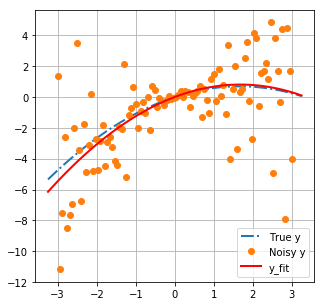

In [13]:
rh.plot_best_fit(x, poly_func, func_fit_best, y_data, 0.25)

## How did we do?

In [14]:
print('True parameters are:              a={0:.4f}, b={1:.4f}, c={2}'.format(*polypars))
print('The best-estimate parameters are: a={0:.4f}, b={1:.4f}, c={2}'.format(*y_fit_pars_best))

True parameters are:              a=-0.2503, b=0.8312, c=0.0
The best-estimate parameters are: a=-0.2864, b=0.9604, c=0


## Make a prediction

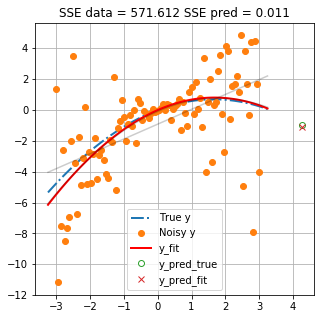

In [15]:
rh.plot_prediction(x, y_data, poly_func, func_fit_best)
#x_predlocations = np.linspace(x[0]-range_x*0.2, x_pred, 1000)
    

### Let's see what happens over a range of polynomial values
We can change the `offset` parameter to plot further outside the data range

We can also change the `extra_degrees` variable to plot curves of higher polynomial degree

In [16]:
range_x = (x[-1]-x[0])
x_pred = x[-1]+range_x*0.21
x_predlocations = np.linspace(x[0]-range_x*0.2, x_pred, 1000)


In [17]:
y_fit_pars = np.polyfit(x,y_data,2)

In [18]:
widgets.interact(rh.plot_poly, cdegree=widgets.IntSlider(min=1,max=30,step=1,value=3),
                 y_fit_pars_best=widgets.fixed(y_fit_pars_best),
                 poly_func=widgets.fixed(poly_func),
                 x=widgets.fixed(x),
                 x_pred=widgets.fixed(x_pred),
                 x_predlocations=widgets.fixed(x_predlocations),
                 y_data=widgets.fixed(y_data), 
                 y_fit_pars=widgets.fixed(y_fit_pars));

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


In [19]:
degree_range=list(range(1,8))
best_degree=2
all_datafit, all_predfit = rh.fit_all_curves(x,x_pred,y_data, poly_func, degree_range)

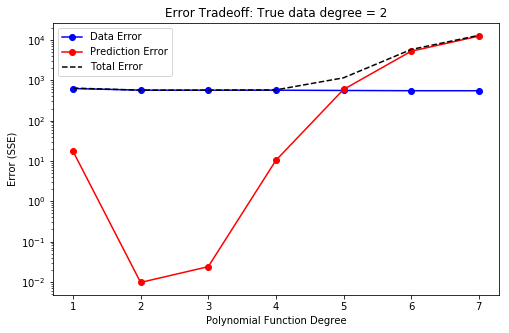

In [20]:
rh.plot_error_tradeoff(all_datafit, all_predfit, degree_range, best_degree)

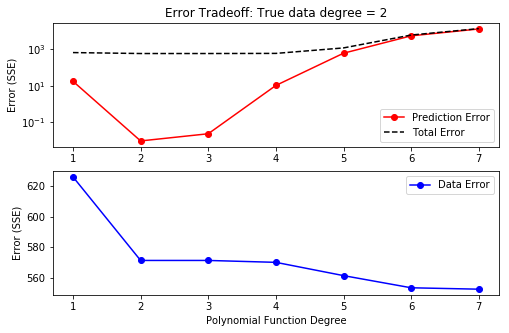

In [21]:
rh.plot_error_tradeoff_fine(all_datafit, all_predfit, degree_range, best_degree)
